In [28]:
import os
import yaml
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from pathlib import Path
from filetrials import FileTrials, space_eval
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Import hyperopt modules
from hyperopt import hp, fmin, tpe

%matplotlib inline

In [29]:
# Fix the seeds for reproducible results
tf.random.set_seed(1234)
np.random.seed(5678)

In [30]:
current_path = Path().absolute()
hyperopt_path = current_path / "hyperopt"
hyperopt_path.mkdir(exist_ok=True)
fits_path = current_path / "fits"
fits_path.mkdir(exist_ok=True)

In [31]:
# load runcard with parameters
def load_runcard(filename):
    with open(f"{current_path}/" + filename, "r") as file:
        input_params = yaml.safe_load(file)
    return input_params

In [32]:
def split_trval(x_data, y_data, perc = 0.3):
    size_val = round(x_data.shape[0]*perc)
    idx = np.random.choice(np.arange(1, x_data.shape[0]-1, 2), size_val, replace=False)
    x_val = x_data[idx]
    y_val = y_data[idx]
    x_tr = np.delete(x_data, idx, axis = 0)
    y_tr = np.delete(y_data, idx)
    return x_tr, y_tr, x_val, y_val

In [34]:
def load_data(runcard):
    filenames = os.listdir(f"{current_path}/data")

    x_sep_data = []
    y_sep_data = []

    for i, filename in enumerate(filenames):
        with open(f"{current_path}/data/" + filename, "r") as file:
            input_data = yaml.safe_load(file)

        x = input_data["x"]
        Q2 = np.array(input_data["Q2"])
        F_2 = np.array(input_data["F_2"])
        F_2_err_stat = np.array(input_data["F_2_err_stat"])
        F_2_err_sys = np.array(input_data["F_2_err_sys"])

        if runcard["Q2_cut"] != None:
            Q2_mask = np.where(Q2 < runcard["Q2_cut"])
            Q2 = Q2[Q2_mask]
            F_2 = F_2[Q2_mask]
            F_2_err_stat = F_2_err_stat[Q2_mask]
            F_2_err_sys = F_2_err_sys[Q2_mask]

        if i == 0:
            x_data = np.zeros((len(Q2), 2))
            x_data[:, 0] = x
            x_data[:, 1] = Q2
            y_data = F_2
            x_sep_data.append(x_data)
            y_sep_data.append(y_data)
            y_err_stat = F_2_err_stat
            y_err_sys = F_2_err_sys
            
            if x_data.shape[0] >= 3:
                x_tr, y_tr, x_val, y_val = split_trval(x_data, y_data, perc=runcard["validation_size"])
                val = True
            else:
                x_tr = x_data
                y_tr = y_data
                val = False
        else:
            x_data_new = np.zeros((len(Q2), 2))
            x_data_new[:, 0] = x
            x_data_new[:, 1] = Q2
            y_data_new = F_2
            y_err_stat_new = F_2_err_stat
            y_err_sys_new = F_2_err_sys
            
            
            if x_data_new.shape[0] >= 3:
                x_tr_new, y_tr_new, x_val_new, y_val_new = split_trval(
                    x_data_new, y_data_new, perc=runcard["validation_size"]
                )
                if val:
                    x_val = np.concatenate([x_val, x_val_new], axis=0)
                    y_val = np.concatenate([y_val, y_val_new], axis=0)
                else:
                    x_val = x_val_new
                    y_val = y_val_new
                    val = True
                
            else:
                x_tr_new = x_data_new
                y_tr_new = y_data_new

            x_tr = np.concatenate([x_tr, x_tr_new], axis=0)
            y_tr = np.concatenate([y_tr, y_tr_new], axis=0)
            y_err_stat = np.concatenate([y_err_stat, y_err_stat_new], axis=0)
            y_err_sys = np.concatenate([y_err_sys, y_err_sys_new], axis=0)
            
            x_sep_data.append(x_data_new)
            y_sep_data.append(y_data_new)
            x_data = np.concatenate([x_data, x_data_new], axis=0)
            y_data = np.concatenate([y_data, y_data_new], axis=0)

    return {
        "x_tr": x_tr,
        "y_tr": y_tr,
        "x_val": x_val,
        "y_val": y_val,
        "x_data": x_data,
        "y_data": y_data,
        "y_err_stat": y_err_stat,
        "y_err_sys": y_err_sys,
        "x_sep_data": x_sep_data,
        "y_sep_data": y_sep_data,
    }

In [35]:
def compute_covmat(data_dict):
    covmat = np.zeros((data_dict["y_data"].shape[0], data_dict["y_data"].shape[0]))
    for i in range(data_dict["y_data"].shape[0]):
        for j in range(data_dict["y_data"].shape[0]):
            covmat[i, j] = (
                data_dict["y_err_sys"][i] * data_dict["y_err_sys"][j]
                + data_dict["y_data"][i] * data_dict["y_data"][j]
            )
            if i == j:
                covmat[i, j] += data_dict["y_err_stat"][i] ** 2
    return covmat

In [37]:
def chi2_with_covmat(covmat, ndata):
    inverted = np.linalg.inv(covmat)
    # Convert numpy array into tensorflow object
    invcovmat = K.constant(inverted)

    def custom_loss(y_true, y_pred):
        # (yt - yp) * covmat * (yt - yp)
        tmp = y_true - y_pred
        import pdb;pdb.set_trace()
        right_dot = tf.tensordot(invcovmat, K.transpose(tmp), axes=1)
        return tf.tensordot(tmp, right_dot, axes=1) / ndata

    return custom_loss

In [38]:
def model_trainer(data_dict, runcard, **hyperparameters):
    # Collect the values for the hyperparameters
    nb_units_layer_1 = hyperparameters.get("units_1", 64)
    nb_units_layer_2 = hyperparameters.get("units_2", 32)
    optimizer = hyperparameters.get("optimizer", "adam")
    activation = hyperparameters.get("activation", "relu")
    epochs = hyperparameters.get("epochs", 10)

    # Construct the model
    model = Sequential()
    model.add(Dense(units=nb_units_layer_1, activation=activation, input_shape=[2]))
    model.add(Dense(units=nb_units_layer_2, activation=activation))
    model.add(Dense(units=1, activation="linear"))

    # Compile the Model as usual
    ndata = data_dict["y_tr"].shape[0]
    covmat = compute_covmat(data_dict)
    #model.compile(loss=chi2_with_covmat(covmat, ndata), optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

    # Callbacks for Early Stopping
    ES = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=0,
        patience=10,
        restore_best_weights=True,
    )

    # Fit the Model as usual
    model.fit(
        data_dict["x_tr"],
        data_dict["y_tr"],
        validation_data=(data_dict["x_val"], data_dict["y_val"]),
        epochs=epochs,
        batch_size=runcard["batch_size"],
        verbose=0,
        callbacks=[ES],
    )

    # Evaluate the Model on the test. Note that this will be the
    # parameter to hyperoptimize. If one wants, one could use x/y_tr.
    # This might be ideal if one have very small number of datapoints
    scores = model.evaluate(data_dict["x_val"], data_dict["y_val"], verbose=0)
    # Return the value of the validation loss
    return model, scores[0]

In [39]:
def define_hyperspace(runcard):
    nb_units_layer_1_choices = runcard["nb_units_layer_1_choices"]
    nb_units_layer_2_choices = runcard["nb_units_layer_2_choices"]
    learning_rate_choices = runcard["learning_rate_choices"]

    nb_units_layer_1 = hp.quniform("units_1", nb_units_layer_1_choices["min"], nb_units_layer_1_choices["max"], nb_units_layer_1_choices["samples"])
    nb_units_layer_2 = hp.quniform("units_2", nb_units_layer_2_choices["min"], nb_units_layer_2_choices["max"], nb_units_layer_2_choices["samples"])
    activation = hp.choice("activation", runcard["activation_choices"])
    optimizer = hp.choice("optimizer", runcard["optimizer_choices"])
    epochs = hp.choice("epochs", runcard["epochs_choices"])
    initializer = hp.choice("initializer", runcard["initializer_choices"])
    learning_rate = hp.loguniform("learning_rate", float(learning_rate_choices["min"]), float(learning_rate_choices["max"]))

    return {
        "units_1": nb_units_layer_1,
        "units_2": nb_units_layer_2,
        "activation": activation,
        "optimizer": optimizer,
        "epochs": epochs,
        "initializer": initializer,
        "learning_rate": learning_rate
    }

In [40]:
def perform_hyperopt(data_dict, runcard):
    hyperspace = define_hyperspace(runcard)

    # Define the hyperoptimization function
    def hyper_function(hyperspace_dict):
        _, val_loss = model_trainer(data_dict, runcard, **hyperspace_dict)
        return {"loss": val_loss, "status": "ok"}

    trials = FileTrials(hyperopt_path, parameters=hyperspace)
    best = fmin(
        fn=hyper_function,
        space=hyperspace,
        verbose=1,
        max_evals=runcard["nb_trials"],
        algo=tpe.suggest,
        trials=trials,
    )
    # Save the best hyperparameters combination in order to return it later
    best_setup = space_eval(hyperspace, best)
    # Write the output of the best into a file
    with open(f"{hyperopt_path}/best_hyperparameters.yaml", "w") as file:
        yaml.dump(best_setup, file, default_flow_style=False)
    # Write the all the history of the hyperopt into a file
    with open(f"{hyperopt_path}/hyperopt_history.pickle", "wb") as histfile:
        pickle.dump(trials.trials, histfile)
    return best_setup

In [41]:
def plot_constant_x(best_model, data_dict):
    # loop over x values
    for i in range(len(data_dict["x_sep_data"])):
        x = data_dict["x_sep_data"][i]
        y = data_dict["y_sep_data"][i]
        x_grid = np.linspace(x[0], x[-1], 100)
        y_pred = best_model(x_grid)
        
        fig, ax = plt.subplots(1, 1) 
        ax.plot(x_grid[:, 1], y_pred, color="red", label="Prediction")
        ax.scatter(x[:, 1], y, color="blue", label="Data")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [42]:
runcard = load_runcard("runcard.yaml")

In [43]:
data_dict = load_data(runcard)

In [44]:
best_params = perform_hyperopt(data_dict, runcard)

100%|█████████| 2/2 [00:21<00:00, 10.53s/trial, best loss: 0.002548759803175926]


In [45]:
best_model,_ = model_trainer(data_dict, runcard, **best_params)

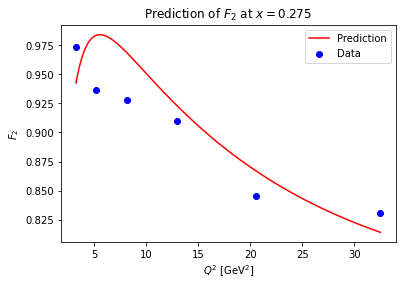

<Figure size 432x288 with 0 Axes>

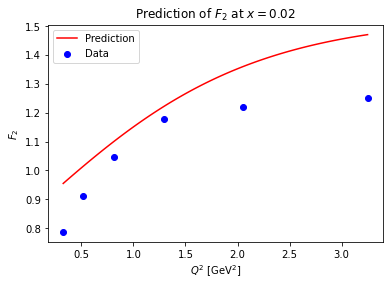

<Figure size 432x288 with 0 Axes>

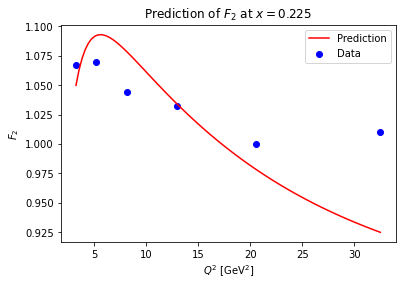

<Figure size 432x288 with 0 Axes>

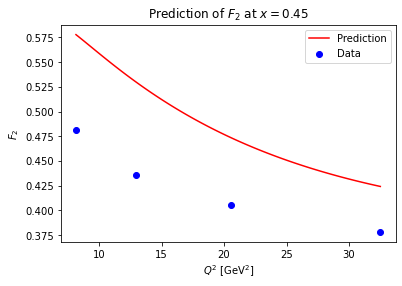

<Figure size 432x288 with 0 Axes>

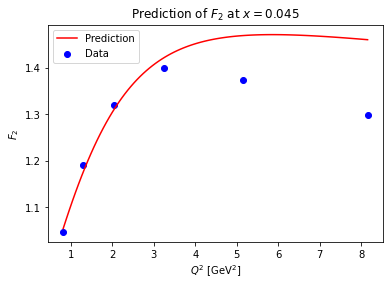

<Figure size 432x288 with 0 Axes>

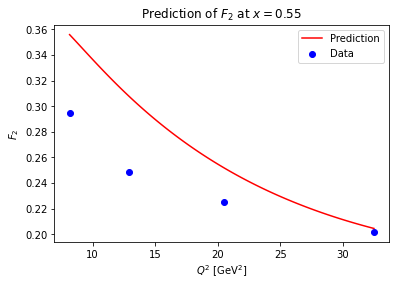

<Figure size 432x288 with 0 Axes>

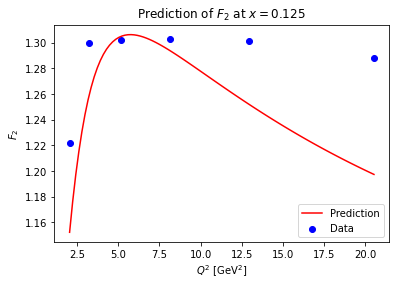

<Figure size 432x288 with 0 Axes>

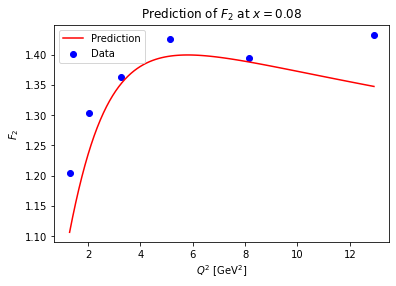

<Figure size 432x288 with 0 Axes>

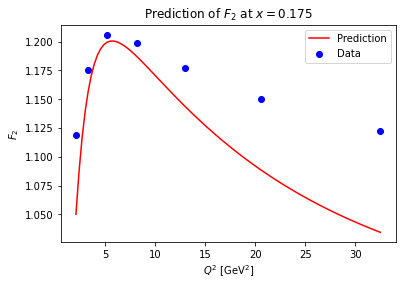

<Figure size 432x288 with 0 Axes>

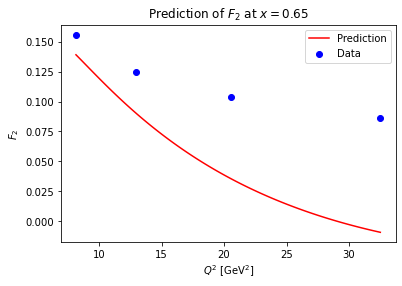

<Figure size 432x288 with 0 Axes>

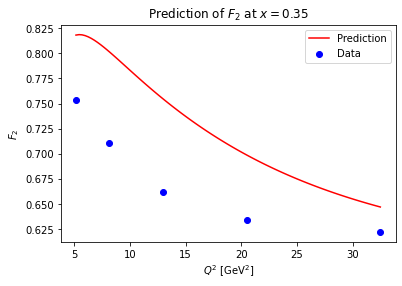

<Figure size 432x288 with 0 Axes>

In [46]:
plot_constant_x(best_model, data_dict)

ADD Inputs runcard:

Add hyperopt nb layers

Seperate scripts:
- hyperopt (combine with filetrials?)
- training (option replicas)
- plotting

filetrials.py:
- change path